In [1]:
%load_ext autoreload
%autoreload 2

# Weak Supervision VAE

Implementing some version of [Weak Supervision Variational Auto-Encoder](https://openreview.net/forum?id=0oDzoRjrbj) by Tonolini et al. 

There are some differences with the paper especially around the decoders and its still a work-in-progress as its mainly tested around the census data at the moment.

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

In [4]:
os.chdir("..")

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [5]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [6]:
from examples.utils import load_wrench_dataset, MetricsUtil

M = {}

Choose your dataset here

In [7]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "youtube"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

C:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [8]:
L_train.shape

(1586, 10)

In [9]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.5333333333333333, 0.4666666666666667]

In [10]:
polarities

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [11]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,1,0.199,1.0,0.186,0.156,0.110
1,1,0.127,1.0,0.108,0.080,0.068
2,1,0.119,1.0,0.102,0.040,0.083
3,1,0.112,1.0,0.110,0.102,0.057
4,0,0.142,1.0,0.112,0.093,0.044
5,1,0.234,1.0,0.133,0.095,0.086
6,0,0.226,1.0,0.144,0.079,0.074
7,0,0.083,1.0,0.061,0.045,0.025
8,0,0.035,1.0,0.032,0.031,0.005
9,0,0.358,1.0,0.262,0.137,0.160


Scoring utils:

In [12]:
y_test = test["label"].astype(int).values

In [13]:
Metrics = MetricsUtil(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [14]:
from flippers.models import Voter

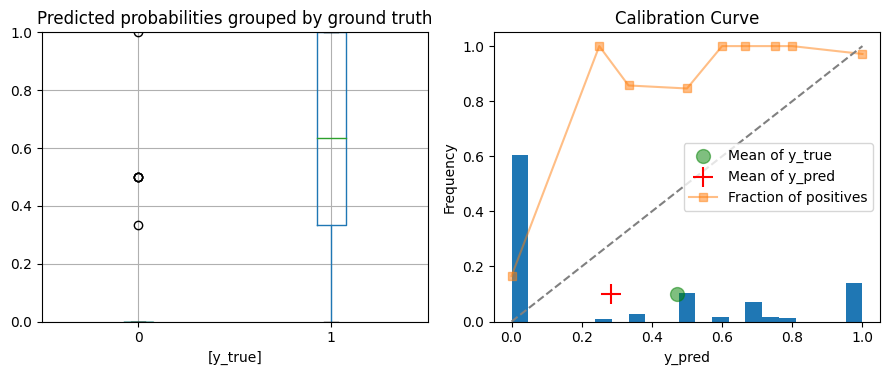

{'F1': 0.692,
 'Average_Precision': 0.861,
 'AUC': 0.879,
 'Accuracy': 0.776,
 'Balanced_Accuracy': 0.763}

In [15]:
preds_vote = Voter(polarities)
Metrics.score(preds_vote, name="MV")

## `flippers`' Snorkel Model

In [16]:
from flippers.models import SnorkelModel

In [17]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(
    L_train,
    verbose=True,
)

Epoch 50/50 | Loss 0.0368: 100%|██████████| 50/50 [00:00<00:00, 799.87it/s]


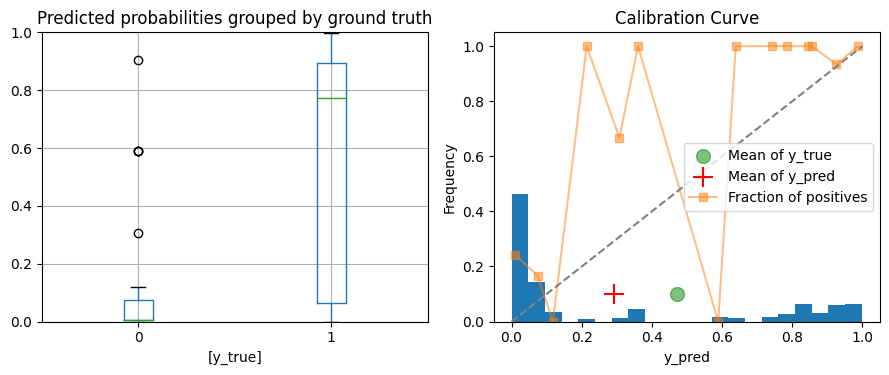

{'F1': 0.723,
 'Average_Precision': 0.867,
 'AUC': 0.823,
 'Accuracy': 0.788,
 'Balanced_Accuracy': 0.777}

In [18]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
Metrics.score(m, name="flippers")

# Weak Label VAE

In [19]:
from examples.Experiments._vae import WeakLabelVAE

In [20]:
L_train.shape

(1586, 10)

Epoch [11/11]: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s, Loss=-5.2]


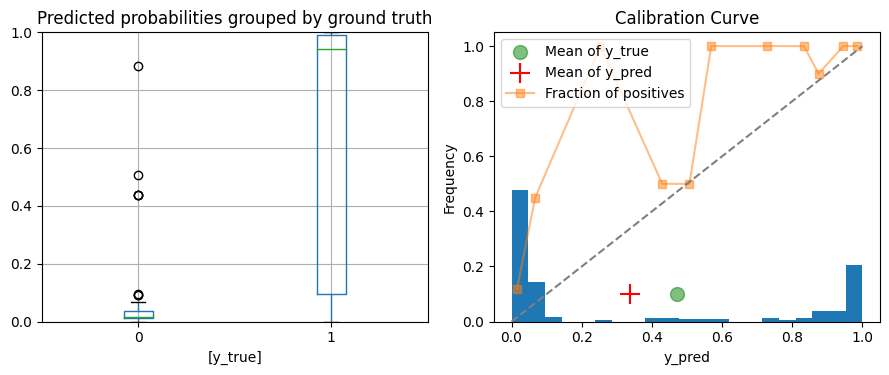

{'F1': 0.812, 'Average_Precision': 0.917, 'AUC': 0.884, 'Accuracy': 0.848, 'Balanced_Accuracy': 0.84}


In [21]:
m = WeakLabelVAE(
    polarities=polarities, class_balances=class_balances, latent_dim=5
)  # .to("cuda")
m.fit(
    L_train,
    learning_rate=1e-3,
    batch_size=16,
    num_batches=1000,
    nudge=10,
    verbose=True,
)
print(Metrics.score(m, name="WeakLabelVAE"))